In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from model import ResnetX
from train import train, acc_func, train_constant_lr
from utility import get_default_device, DeviceDataLoader, to_device

In [2]:
data_statistics = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # (mean, s.d.)

train_transforms = transform.Compose([transform.RandomCrop(32, padding=4, padding_mode="reflect"),
                                      transform.RandomHorizontalFlip(),
                                      transform.ToTensor(),
                                      transform.Normalize(*data_statistics, inplace=True)])

test_transforms = transform.Compose([transform.ToTensor(),
                                     transform.Normalize(*data_statistics, inplace=True)])

train_dataset = torchvision.datasets.CIFAR10(root="./Datasets/",
                                             train=True,
                                             transform=train_transforms,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root="./Datasets/",
                                            train=False,
                                            transform=test_transforms,
                                            download=True)

validation_ratio = 0.2
train_dataset, validation_dataset = random_split(train_dataset, [int((1 - validation_ratio) * len(train_dataset)), 
                                                                 int(validation_ratio * len(train_dataset))])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, pin_memory=True)

In [4]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

model = ResnetX(3, 10)
model = to_device(model, device)
print(model)

ResnetX(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (conv1res1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2res1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2):

In [5]:
epochs = 10
max_lr = 0.01
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam
results = train(model, train_loader, validation_loader, epochs, max_lr, loss_func, optim)

Epoch [1/10], Step [100/1250], Loss: 1.8144, Acc: 0.3438
Epoch [1/10], Step [200/1250], Loss: 1.6685, Acc: 0.4375
Epoch [1/10], Step [300/1250], Loss: 1.9911, Acc: 0.4062
Epoch [1/10], Step [400/1250], Loss: 1.6473, Acc: 0.3438
Epoch [1/10], Step [500/1250], Loss: 1.5723, Acc: 0.4062
Epoch [1/10], Step [600/1250], Loss: 1.4003, Acc: 0.5312
Epoch [1/10], Step [700/1250], Loss: 1.8812, Acc: 0.3125
Epoch [1/10], Step [800/1250], Loss: 1.3570, Acc: 0.5312
Epoch [1/10], Step [900/1250], Loss: 1.0175, Acc: 0.6875
Epoch [1/10], Step [1000/1250], Loss: 1.2082, Acc: 0.5312
Epoch [1/10], Step [1100/1250], Loss: 1.3438, Acc: 0.5312
Epoch [1/10], Step [1200/1250], Loss: 1.7128, Acc: 0.5000
Avg train loss: 1.5133, Avg train acc: 0.4795
Avg validation loss: 1.3861, Avg validation acc: 0.5601
Epoch [2/10], Step [100/1250], Loss: 1.4715, Acc: 0.5625
Epoch [2/10], Step [200/1250], Loss: 1.4961, Acc: 0.5625
Epoch [2/10], Step [300/1250], Loss: 1.0296, Acc: 0.6562
Epoch [2/10], Step [400/1250], Loss: 1.1

KeyboardInterrupt: 

In [10]:
test_acc = []

for images, labels in test_loader:
    with torch.no_grad():
        logits = model(images)
    accuracy = acc_func(logits, labels)
    test_acc.append(accuracy)
print("test_accuracy: ", torch.stack(test_acc).mean().item())

test_accuracy:  0.9032548069953918


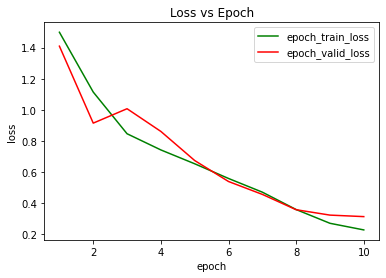

In [11]:
x1 = results["epoch_train_losses"]
x2 = results["epoch_valid_losses"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_loss')
plt.plot(y, x2, 'r', label='epoch_valid_loss')

plt.title("Loss vs Epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.legend()
plt.show()

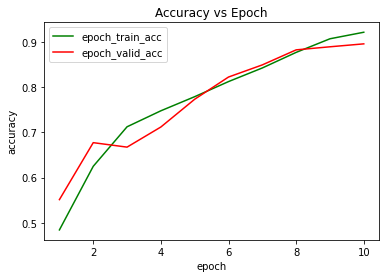

In [12]:
x1 = results["epoch_train_accs"]
x2 = results["epoch_valid_accs"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_acc')
plt.plot(y, x2, 'r', label='epoch_valid_acc')

plt.title("Accuracy vs Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.legend()
plt.show()

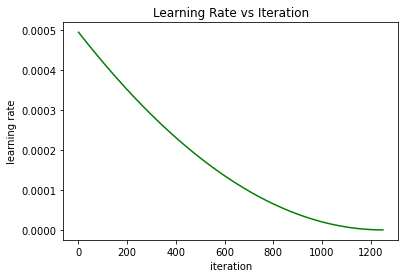

In [13]:
x = results["learning_rate"]
y = range(1, len(results["learning_rate"]) + 1)
    
plt.plot(y, x, 'g')

plt.title("Learning Rate vs Iteration")
plt.xlabel("iteration")
plt.ylabel("learning rate")

plt.show()

In [14]:
print("time_batch_size_32: ", results["computation_time"] )

time:  453.6060519218445


In [ ]:
filename = "finalized_resnet_model.ckpt"
torch.save(model.state_dict(), filename)

Test batch size = 16

In [17]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, pin_memory=True)

device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

model = ResnetX(3, 10)
model = to_device(model, device)

results = train(model, train_loader, validation_loader, epochs, max_lr, loss_func, optim)

Epoch [1/10], Step [100/2500], Loss: 1.8343, Acc: 0.5000
Epoch [1/10], Step [200/2500], Loss: 2.0933, Acc: 0.1875
Epoch [1/10], Step [300/2500], Loss: 1.7896, Acc: 0.1875
Epoch [1/10], Step [400/2500], Loss: 1.6696, Acc: 0.3750
Epoch [1/10], Step [500/2500], Loss: 1.5704, Acc: 0.3125
Epoch [1/10], Step [600/2500], Loss: 1.0906, Acc: 0.5625
Epoch [1/10], Step [700/2500], Loss: 1.7328, Acc: 0.1875
Epoch [1/10], Step [800/2500], Loss: 1.5775, Acc: 0.4375
Epoch [1/10], Step [900/2500], Loss: 1.5475, Acc: 0.3750
Epoch [1/10], Step [1000/2500], Loss: 1.6581, Acc: 0.2500
Epoch [1/10], Step [1100/2500], Loss: 0.8715, Acc: 0.7500
Epoch [1/10], Step [1200/2500], Loss: 1.4701, Acc: 0.4375
Epoch [1/10], Step [1300/2500], Loss: 1.5016, Acc: 0.5625
Epoch [1/10], Step [1400/2500], Loss: 1.5610, Acc: 0.3750
Epoch [1/10], Step [1500/2500], Loss: 1.9904, Acc: 0.3750
Epoch [1/10], Step [1600/2500], Loss: 2.5794, Acc: 0.3125
Epoch [1/10], Step [1700/2500], Loss: 1.5655, Acc: 0.5000
Epoch [1/10], Step [180

Epoch [6/10], Step [1000/2500], Loss: 0.3146, Acc: 0.8750
Epoch [6/10], Step [1100/2500], Loss: 0.9247, Acc: 0.6875
Epoch [6/10], Step [1200/2500], Loss: 0.9583, Acc: 0.6875
Epoch [6/10], Step [1300/2500], Loss: 0.8715, Acc: 0.7500
Epoch [6/10], Step [1400/2500], Loss: 0.4731, Acc: 0.8750
Epoch [6/10], Step [1500/2500], Loss: 0.8218, Acc: 0.8125
Epoch [6/10], Step [1600/2500], Loss: 0.5367, Acc: 0.8125
Epoch [6/10], Step [1700/2500], Loss: 0.6131, Acc: 0.8750
Epoch [6/10], Step [1800/2500], Loss: 0.7597, Acc: 0.8125
Epoch [6/10], Step [1900/2500], Loss: 0.3625, Acc: 0.8750
Epoch [6/10], Step [2000/2500], Loss: 0.4101, Acc: 0.9375
Epoch [6/10], Step [2100/2500], Loss: 0.5238, Acc: 0.8750
Epoch [6/10], Step [2200/2500], Loss: 0.6939, Acc: 0.8750
Epoch [6/10], Step [2300/2500], Loss: 0.1072, Acc: 1.0000
Epoch [6/10], Step [2400/2500], Loss: 1.0161, Acc: 0.8125
Epoch [6/10], Step [2500/2500], Loss: 0.4643, Acc: 0.8125
Avg train loss: 0.6445, Avg train acc: 0.7840
Avg validation loss: 0.550

In [18]:
test_acc = []

for images, labels in test_loader:
    with torch.no_grad():
        logits = model(images)
    accuracy = acc_func(logits, labels)
    test_acc.append(accuracy)
print("test_accuracy: ", torch.stack(test_acc).mean().item())

test_accuracy:  0.8888999819755554


In [20]:
print("time_batch_size_16: ", results["computation_time"] )

time_batch_size_16:  1667.7726259231567


Test batch size = 64

In [21]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, pin_memory=True)

device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

model = ResnetX(3, 10)
model = to_device(model, device)

results = train(model, train_loader, validation_loader, epochs, max_lr, loss_func, optim)

Epoch [1/10], Step [100/625], Loss: 1.5855, Acc: 0.3906
Epoch [1/10], Step [200/625], Loss: 1.4022, Acc: 0.5312
Epoch [1/10], Step [300/625], Loss: 1.4444, Acc: 0.5312
Epoch [1/10], Step [400/625], Loss: 1.2235, Acc: 0.5469
Epoch [1/10], Step [500/625], Loss: 0.9975, Acc: 0.6406
Epoch [1/10], Step [600/625], Loss: 1.1621, Acc: 0.5625
Avg train loss: 1.4544, Avg train acc: 0.4921
Avg validation loss: 1.2070, Avg validation acc: 0.5899
Epoch [2/10], Step [100/625], Loss: 1.5255, Acc: 0.4844
Epoch [2/10], Step [200/625], Loss: 1.4190, Acc: 0.5469
Epoch [2/10], Step [300/625], Loss: 1.5811, Acc: 0.4688
Epoch [2/10], Step [400/625], Loss: 0.9802, Acc: 0.6719
Epoch [2/10], Step [500/625], Loss: 1.1084, Acc: 0.6094
Epoch [2/10], Step [600/625], Loss: 1.1310, Acc: 0.6094
Avg train loss: 1.1197, Avg train acc: 0.6256
Avg validation loss: 1.1936, Avg validation acc: 0.6075
Epoch [3/10], Step [100/625], Loss: 1.1596, Acc: 0.6719
Epoch [3/10], Step [200/625], Loss: 0.9819, Acc: 0.7500
Epoch [3/10]

In [22]:
test_acc = []

for images, labels in test_loader:
    with torch.no_grad():
        logits = model(images)
    accuracy = acc_func(logits, labels)
    test_acc.append(accuracy)
print("test_accuracy: ", torch.stack(test_acc).mean().item())

test_accuracy:  0.9048566818237305


In [23]:
print("time_batch_size_64: ", results["computation_time"] )

time_batch_size_64:  384.9242615699768


Test batch size = 128

In [24]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, pin_memory=True)

device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

model = ResnetX(3, 10)
model = to_device(model, device)

results = train(model, train_loader, validation_loader, epochs, max_lr, loss_func, optim)

Epoch [1/10], Step [100/313], Loss: 1.4146, Acc: 0.4609
Epoch [1/10], Step [200/313], Loss: 1.2902, Acc: 0.5391
Epoch [1/10], Step [300/313], Loss: 1.4529, Acc: 0.5391
Avg train loss: 1.5057, Avg train acc: 0.4744
Avg validation loss: 1.3271, Avg validation acc: 0.5475
Epoch [2/10], Step [100/313], Loss: 0.9874, Acc: 0.6562
Epoch [2/10], Step [200/313], Loss: 1.0985, Acc: 0.6562
Epoch [2/10], Step [300/313], Loss: 0.9720, Acc: 0.6484
Avg train loss: 1.1455, Avg train acc: 0.6120
Avg validation loss: 1.6558, Avg validation acc: 0.5145
Epoch [3/10], Step [100/313], Loss: 0.8438, Acc: 0.6875
Epoch [3/10], Step [200/313], Loss: 0.8291, Acc: 0.7109
Epoch [3/10], Step [300/313], Loss: 0.6350, Acc: 0.7266
Avg train loss: 0.8474, Avg train acc: 0.7141
Avg validation loss: 1.1184, Avg validation acc: 0.6528
Epoch [4/10], Step [100/313], Loss: 0.7438, Acc: 0.7266
Epoch [4/10], Step [200/313], Loss: 0.7384, Acc: 0.7031
Epoch [4/10], Step [300/313], Loss: 0.4766, Acc: 0.8047
Avg train loss: 0.6439

In [25]:
test_acc = []

for images, labels in test_loader:
    with torch.no_grad():
        logits = model(images)
    accuracy = acc_func(logits, labels)
    test_acc.append(accuracy)
print("test_accuracy: ", torch.stack(test_acc).mean().item())

test_accuracy:  0.9054588675498962


In [26]:
print("time_batch_size_128: ", results["computation_time"] )

time_batch_size_128:  353.6407928466797


Test constant lr 0.01

In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, pin_memory=True)

device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

model = ResnetX(3, 10)
model = to_device(model, device)

epochs = 10
lr = 0.01
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam

results = train_constant_lr(model, train_loader, validation_loader, epochs, lr, loss_func, optim)

Epoch [1/10], Step [100/1250], Loss: 2.2814, Acc: 0.1875
Epoch [1/10], Step [200/1250], Loss: 1.8339, Acc: 0.4062
Epoch [1/10], Step [300/1250], Loss: 2.3088, Acc: 0.2500
Epoch [1/10], Step [400/1250], Loss: 1.7297, Acc: 0.5312
Epoch [1/10], Step [500/1250], Loss: 2.1582, Acc: 0.2500
Epoch [1/10], Step [600/1250], Loss: 1.5156, Acc: 0.4688
Epoch [1/10], Step [700/1250], Loss: 1.5924, Acc: 0.2812
Epoch [1/10], Step [800/1250], Loss: 1.3810, Acc: 0.5312
Epoch [1/10], Step [900/1250], Loss: 1.7614, Acc: 0.4375
Epoch [1/10], Step [1000/1250], Loss: 1.1595, Acc: 0.5938
Epoch [1/10], Step [1100/1250], Loss: 1.0068, Acc: 0.5938
Epoch [1/10], Step [1200/1250], Loss: 1.5113, Acc: 0.4062
Avg train loss: 1.9238, Avg train acc: 0.3815
Avg validation loss: 1.2934, Avg validation acc: 0.5668
Epoch [2/10], Step [100/1250], Loss: 1.5406, Acc: 0.4375
Epoch [2/10], Step [200/1250], Loss: 1.5614, Acc: 0.5000
Epoch [2/10], Step [300/1250], Loss: 1.4516, Acc: 0.5000
Epoch [2/10], Step [400/1250], Loss: 1.2

In [7]:
test_acc = []

for images, labels in test_loader:
    with torch.no_grad():
        logits = model(images)
    accuracy = acc_func(logits, labels)
    test_acc.append(accuracy)
print("test_accuracy: ", torch.stack(test_acc).mean().item())

test_accuracy:  0.8144968152046204
time_constant_lr_0.01:  435.5223183631897


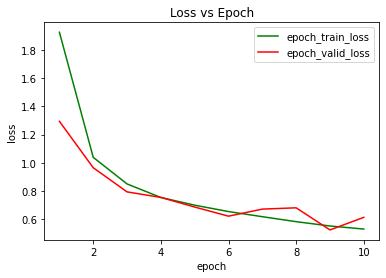

In [10]:
x1 = results["epoch_train_losses"]
x2 = results["epoch_valid_losses"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_loss')
plt.plot(y, x2, 'r', label='epoch_valid_loss')

plt.title("Loss vs Epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.legend()
plt.show()

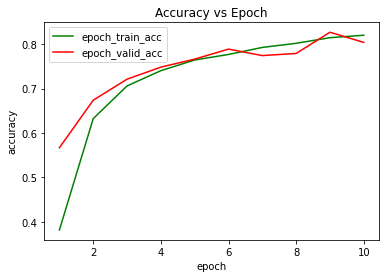

In [11]:
x1 = results["epoch_train_accs"]
x2 = results["epoch_valid_accs"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_acc')
plt.plot(y, x2, 'r', label='epoch_valid_acc')

plt.title("Accuracy vs Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.legend()
plt.show()

Test constant lr 0.0001

In [21]:
model = ResnetX(3, 10)
model = to_device(model, device)

epochs = 10
lr = 0.0001
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam

results = train_constant_lr(model, train_loader, validation_loader, epochs, lr, loss_func, optim)

Epoch [1/10], Step [100/1250], Loss: 1.8573, Acc: 0.4062
Epoch [1/10], Step [200/1250], Loss: 1.8601, Acc: 0.3438
Epoch [1/10], Step [300/1250], Loss: 1.9978, Acc: 0.3438
Epoch [1/10], Step [400/1250], Loss: 1.3617, Acc: 0.4062
Epoch [1/10], Step [500/1250], Loss: 1.2521, Acc: 0.5312
Epoch [1/10], Step [600/1250], Loss: 1.1905, Acc: 0.5938
Epoch [1/10], Step [700/1250], Loss: 1.7090, Acc: 0.4375
Epoch [1/10], Step [800/1250], Loss: 1.4339, Acc: 0.4375
Epoch [1/10], Step [900/1250], Loss: 1.1291, Acc: 0.5312
Epoch [1/10], Step [1000/1250], Loss: 1.1659, Acc: 0.6875
Epoch [1/10], Step [1100/1250], Loss: 1.0654, Acc: 0.6562
Epoch [1/10], Step [1200/1250], Loss: 1.4893, Acc: 0.5000
Avg train loss: 1.4545, Avg train acc: 0.4931
Avg validation loss: 1.0074, Avg validation acc: 0.6502
Epoch [2/10], Step [100/1250], Loss: 0.9289, Acc: 0.6562
Epoch [2/10], Step [200/1250], Loss: 1.3371, Acc: 0.5312
Epoch [2/10], Step [300/1250], Loss: 1.6530, Acc: 0.4375
Epoch [2/10], Step [400/1250], Loss: 1.1

In [22]:
test_acc = []

for images, labels in test_loader:
    with torch.no_grad():
        logits = model(images)
    accuracy = acc_func(logits, labels)
    test_acc.append(accuracy)
print("test_accuracy: ", torch.stack(test_acc).mean().item())

test_accuracy:  0.8729033470153809


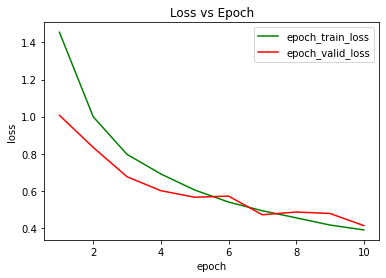

In [23]:
x1 = results["epoch_train_losses"]
x2 = results["epoch_valid_losses"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_loss')
plt.plot(y, x2, 'r', label='epoch_valid_loss')

plt.title("Loss vs Epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.legend()
plt.show()

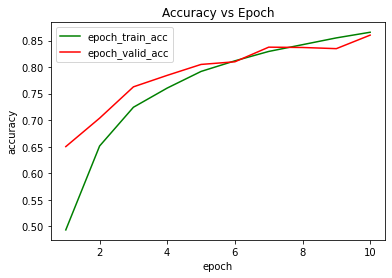

In [24]:
x1 = results["epoch_train_accs"]
x2 = results["epoch_valid_accs"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_acc')
plt.plot(y, x2, 'r', label='epoch_valid_acc')

plt.title("Accuracy vs Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.legend()
plt.show()

Test constatn lr 0.001

In [12]:
model = ResnetX(3, 10)
model = to_device(model, device)

epochs = 10
lr = 0.001
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam

results = train_constant_lr(model, train_loader, validation_loader, epochs, lr, loss_func, optim)

Epoch [1/10], Step [100/1250], Loss: 1.3593, Acc: 0.5312
Epoch [1/10], Step [200/1250], Loss: 1.8209, Acc: 0.3125
Epoch [1/10], Step [300/1250], Loss: 1.7381, Acc: 0.3438
Epoch [1/10], Step [400/1250], Loss: 1.2370, Acc: 0.5625
Epoch [1/10], Step [500/1250], Loss: 1.2420, Acc: 0.5938
Epoch [1/10], Step [600/1250], Loss: 1.1336, Acc: 0.5625
Epoch [1/10], Step [700/1250], Loss: 1.3926, Acc: 0.5938
Epoch [1/10], Step [800/1250], Loss: 0.7296, Acc: 0.7812
Epoch [1/10], Step [900/1250], Loss: 1.1431, Acc: 0.5938
Epoch [1/10], Step [1000/1250], Loss: 1.3556, Acc: 0.4688
Epoch [1/10], Step [1100/1250], Loss: 1.4957, Acc: 0.5000
Epoch [1/10], Step [1200/1250], Loss: 1.1241, Acc: 0.6875
Avg train loss: 1.4322, Avg train acc: 0.4974
Avg validation loss: 1.0572, Avg validation acc: 0.6379
Epoch [2/10], Step [100/1250], Loss: 1.1673, Acc: 0.4375
Epoch [2/10], Step [200/1250], Loss: 0.9058, Acc: 0.7812
Epoch [2/10], Step [300/1250], Loss: 0.7900, Acc: 0.6875
Epoch [2/10], Step [400/1250], Loss: 1.4

In [14]:
test_acc = []

for images, labels in test_loader:
    with torch.no_grad():
        logits = model(images)
    accuracy = acc_func(logits, labels)
    test_acc.append(accuracy)
print("test_accuracy: ", torch.stack(test_acc).mean().item())

test_accuracy:  0.8473442196846008


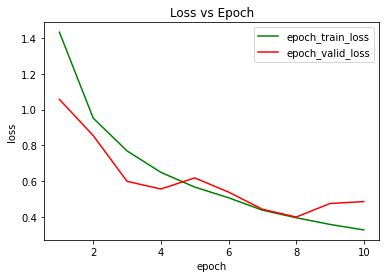

In [15]:
x1 = results["epoch_train_losses"]
x2 = results["epoch_valid_losses"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_loss')
plt.plot(y, x2, 'r', label='epoch_valid_loss')

plt.title("Loss vs Epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.legend()
plt.show()

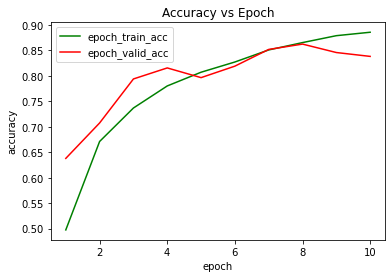

In [16]:
x1 = results["epoch_train_accs"]
x2 = results["epoch_valid_accs"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_acc')
plt.plot(y, x2, 'r', label='epoch_valid_acc')

plt.title("Accuracy vs Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.legend()
plt.show()

Test constatn lr 0.1

In [17]:
model = ResnetX(3, 10)
model = to_device(model, device)

epochs = 10
lr = 0.1
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam

results = train_constant_lr(model, train_loader, validation_loader, epochs, lr, loss_func, optim)

Epoch [1/10], Step [100/1250], Loss: 2.3011, Acc: 0.0938
Epoch [1/10], Step [200/1250], Loss: 2.3227, Acc: 0.2188
Epoch [1/10], Step [300/1250], Loss: 2.3072, Acc: 0.0938
Epoch [1/10], Step [400/1250], Loss: 2.1550, Acc: 0.1250
Epoch [1/10], Step [500/1250], Loss: 2.2358, Acc: 0.1250
Epoch [1/10], Step [600/1250], Loss: 2.1165, Acc: 0.1250
Epoch [1/10], Step [700/1250], Loss: 2.0816, Acc: 0.3750
Epoch [1/10], Step [800/1250], Loss: 2.1929, Acc: 0.2188
Epoch [1/10], Step [900/1250], Loss: 2.1049, Acc: 0.2500
Epoch [1/10], Step [1000/1250], Loss: 2.1275, Acc: 0.0938
Epoch [1/10], Step [1100/1250], Loss: 2.1076, Acc: 0.1875
Epoch [1/10], Step [1200/1250], Loss: 2.0608, Acc: 0.1562
Avg train loss: 2.5558, Avg train acc: 0.1504
Avg validation loss: 2.1018, Avg validation acc: 0.1569
Epoch [2/10], Step [100/1250], Loss: 2.2386, Acc: 0.1562
Epoch [2/10], Step [200/1250], Loss: 2.0838, Acc: 0.1875
Epoch [2/10], Step [300/1250], Loss: 2.1235, Acc: 0.2500
Epoch [2/10], Step [400/1250], Loss: 2.0

In [18]:
test_acc = []

for images, labels in test_loader:
    with torch.no_grad():
        logits = model(images)
    accuracy = acc_func(logits, labels)
    test_acc.append(accuracy)
print("test_accuracy: ", torch.stack(test_acc).mean().item())

test_accuracy:  0.24870207905769348


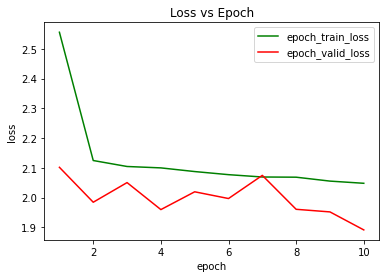

In [19]:
x1 = results["epoch_train_losses"]
x2 = results["epoch_valid_losses"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_loss')
plt.plot(y, x2, 'r', label='epoch_valid_loss')

plt.title("Loss vs Epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.legend()
plt.show()

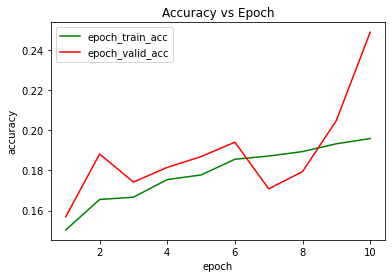

In [20]:
x1 = results["epoch_train_accs"]
x2 = results["epoch_valid_accs"]
y = range(1, epochs + 1)
    
plt.plot(y, x1, 'g', label='epoch_train_acc')
plt.plot(y, x2, 'r', label='epoch_valid_acc')

plt.title("Accuracy vs Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.legend()
plt.show()